# Understanding Bayes Factors vs. P-values

This tutorial compares two approaches to statistical inference in social science:
1. Traditional Null Hypothesis Significance Testing (NHST) using p-values
2. Bayesian hypothesis testing using Bayes Factors

We'll use Python to simulate studies and compare how these methods interpret the same data.

## Key Differences
- **P-values**: Probability of observing data this extreme under the null hypothesis
- **Bayes Factors**: Relative evidence for competing hypotheses (H1 vs H0)

## The Hypotheses

In this demonstration, we're comparing two groups (control and treatment) with the following hypotheses:

- **Null Hypothesis (H0)**: There is no difference between the groups (i.e., the treatment has no effect)
   - Mathematically: μ₁ = μ₂ (the population means are equal)

- **Alternative Hypothesis (H1)**: There is a difference between the groups (i.e., the treatment has an effect)
   - Mathematically: μ₁ ≠ μ₂ (the population means are different)

## Interpreting the Evidence

### P-values
- p < 0.05: Reject H0 (evidence against no difference)
- p ≥ 0.05: Fail to reject H0 (insufficient evidence against no difference)

### Bayes Factors
- BF10 is the odds of H1 over H0:
  - BF10 > 3: Evidence favors the alternative (there is a difference)
  - BF10 < 1/3: Evidence favors the null (there is no difference)
  - 1/3 ≤ BF10 ≤ 3: Evidence is inconclusive

- BF01 (=1/BF10) is the odds of H0 over H1

## Implementation Details

In our simulation:
- Control group is drawn from N(0,1)
- Treatment group is drawn from N(d,1) where d is the effect size
- Effect size d=0 represents H0 being true
- Effect size d≠0 represents H1 being true

## Setup
First, let's import our required libraries:

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import gamma

# Set random seed for reproducibility
np.random.seed(42)

## Implementing Bayes Factor Calculation

We'll implement the JZS (Jeffreys-Zellner-Siow) Bayes Factor, which is commonly used for two-sample comparisons. This approach uses a Cauchy prior on the standardized effect size.

In [34]:
def calculate_bayes_factor(data1, data2, mu_prior=0, sigma_prior=.2):
    """Calculate Bayes Factor for two-sample comparison.
    
    Args:
        data1, data2: Arrays of observations from two groups
        mu_prior: Prior mean (default=0)
        sigma_prior: Prior standard deviation (default=1)
    
    Returns:
        BF10: Bayes Factor (>1 favors H1, <1 favors H0)
    """
    n1, n2 = len(data1), len(data2)
    
    # Calculate sample statistics
    mean1, mean2 = np.mean(data1), np.mean(data2)
    var1, var2 = np.var(data1, ddof=1), np.var(data2, ddof=1)
    
    # Pooled variance
    sp = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
    
    # Calculate t-statistic
    t_stat = (mean1 - mean2)/(sp*np.sqrt(1/n1 + 1/n2))
    
    # Calculate degrees of freedom
    df = n1 + n2 - 2
    
    # Calculate Bayes Factor using JZS prior
    g = 1  # Scale factor for prior
    
    # Components of BF calculation
    bf10 = (1 + t_stat**2/(df))**(-0.5*(df+1))
    bf10 *= gamma((df+1)/2)/gamma(df/2)
    bf10 *= (df/2)**0.5
    bf10 *= (1 + g)**0.5
    
    return 1 / bf10  # Return the inverse to get BF10

## Simulating Studies

Let's create functions to simulate studies with different effect sizes. This will help us understand how both methods behave under different conditions.

In [35]:
def simulate_study(n_subjects=100, effect_size=0.5, random_seed=None):
    """Simulate a study comparing two groups with specified effect size.
    
    Args:
        n_subjects: Number of subjects per group
        effect_size: Cohen's d effect size
        random_seed: Optional random seed for reproducibility
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    control = np.random.normal(0, 1, n_subjects)
    treatment = np.random.normal(effect_size, 1, n_subjects)
    
    return control, treatment

def run_comparison(control, treatment):
    """Run both traditional t-test and Bayes Factor analysis"""
    t_stat, p_value = stats.ttest_ind(control, treatment)
    bf10 = calculate_bayes_factor(control, treatment)
    
    return t_stat, p_value, bf10

## Comparing Methods Across Different Effect Sizes

Let's simulate studies with different effect sizes and compare how p-values and Bayes Factors interpret the results.

In [36]:
effect_sizes = [0, 0.2, 0.5, 0.8]  # Range from null to large effect
n_subjects = 30
results = []

for effect_size in effect_sizes:
    control, treatment = simulate_study(n_subjects=n_subjects, effect_size=effect_size)
    t_stat, p_value, bf10 = run_comparison(control, treatment)
    
    results.append({
        'effect_size': effect_size,
        't_stat': t_stat,
        'p_value': p_value,
        'BF10': bf10,
        'BF01': 1/bf10
    })

# Create formatted results table
print("Comparison of p-values and Bayes Factors across effect sizes:")
print("-" * 80)
print(f"{'Effect Size':^12} {'t-stat':^12} {'p-value':^12} {'BF10':^12} {'BF01':^12} {'Interpretation':^20}")
print("-" * 80)

for r in results:
    interpretation = ""
    if r['BF10'] > 3:
        interpretation = "Support for H1"
    elif r['BF10'] < 1/3:
        interpretation = "Support for H0"
    else:
        interpretation = "Inconclusive"
        
    print(f"{r['effect_size']:^12.2f} {r['t_stat']:^12.2f} {r['p_value']:^12.3f} "
          f"{r['BF10']:^12.2f} {r['BF01']:^12.2f} {interpretation:^20}")

Comparison of p-values and Bayes Factors across effect sizes:
--------------------------------------------------------------------------------
Effect Size     t-stat      p-value        BF10         BF01        Interpretation   
--------------------------------------------------------------------------------
    0.00         0.13        0.893         0.02        40.46        Support for H0   
    0.20        -2.25        0.028         0.29         3.44        Support for H0   
    0.50        -1.79        0.079         0.12         8.39        Support for H0   
    0.80        -3.89        0.000        22.95         0.04        Support for H1   


/tmp/ipykernel_12523/1609195336.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  posterior /= np.trapz(posterior, x)  # Normalize the posterior


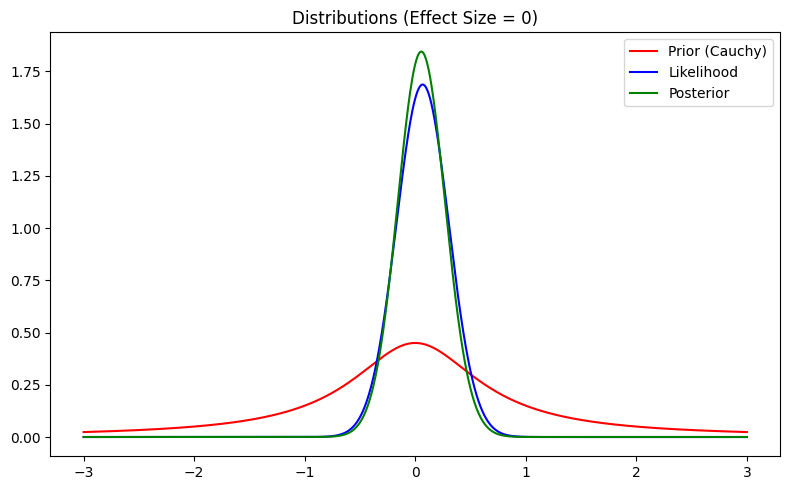

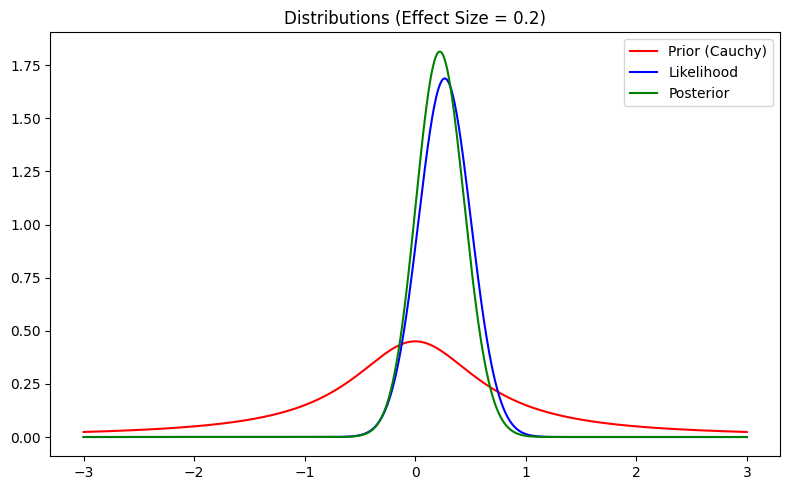

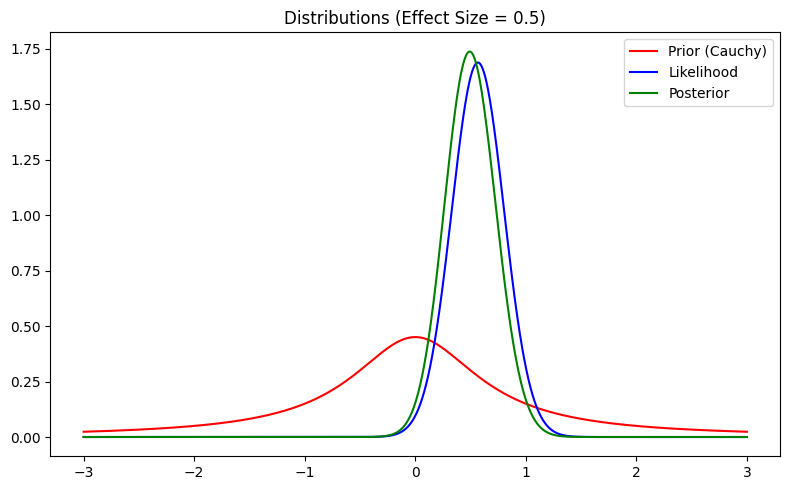

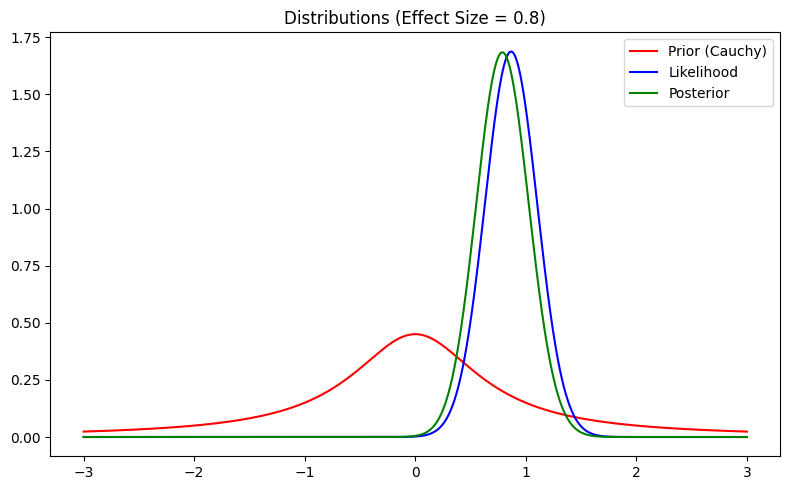

In [32]:
def plot_distributions(effect_size, control, treatment):
    """Plot prior, likelihood, and posterior distributions for given effect size."""
    fig, ax = plt.subplots(figsize=(8, 5))

    # Prior distribution (Cauchy prior on effect size)
    x = np.linspace(-3, 3, 1000)
    prior = stats.cauchy.pdf(x, loc=0, scale=0.707)
    ax.plot(x, prior, 'r-', label='Prior (Cauchy)')

    # Likelihood distribution (based on observed data)
    mean_diff = np.mean(treatment) - np.mean(control)
    pooled_var = (np.var(control, ddof=1) + np.var(treatment, ddof=1)) / 2
    se_diff = np.sqrt(pooled_var * (2 / len(control)))
    likelihood = stats.norm.pdf(x, loc=mean_diff, scale=se_diff)
    ax.plot(x, likelihood, 'b-', label='Likelihood')

    # Posterior distribution (using Bayes' theorem)
    posterior = prior * likelihood
    posterior /= np.trapz(posterior, x)  # Normalize the posterior
    ax.plot(x, posterior, 'g-', label='Posterior')

    ax.set_title(f'Distributions (Effect Size = {effect_size})')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Plot distributions for each effect size
for effect_size in effect_sizes:
    control, treatment = simulate_study(n_subjects=n_subjects, effect_size=effect_size, random_seed=42)
    plot_distributions(effect_size, control, treatment)


## Visualizing the Results

Let's create a visualization to compare how p-values and Bayes Factors respond to different effect sizes.

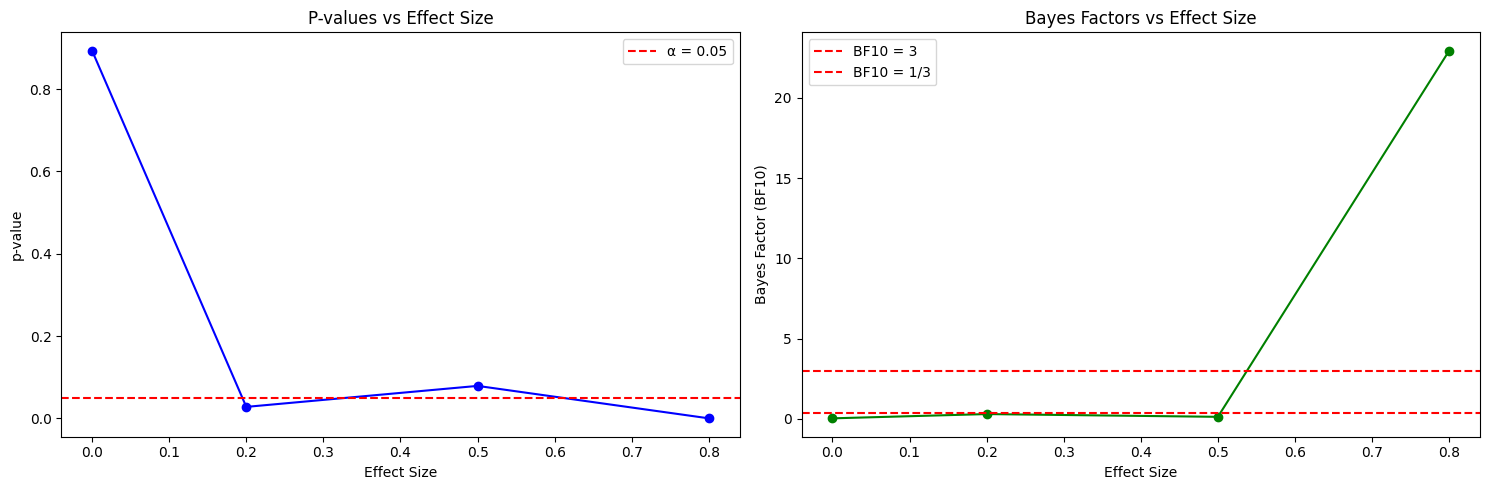

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot p-values
ax1.plot([r['effect_size'] for r in results], 
         [r['p_value'] for r in results], 
         'b-o')
ax1.axhline(y=0.05, color='r', linestyle='--', label='α = 0.05')
ax1.set_xlabel('Effect Size')
ax1.set_ylabel('p-value')
ax1.set_title('P-values vs Effect Size')
ax1.legend()

# Plot Bayes Factors
ax2.plot([r['effect_size'] for r in results], 
         [r['BF10'] for r in results], 
         'g-o')
ax2.axhline(y=3, color='r', linestyle='--', label='BF10 = 3')
ax2.axhline(y=1/3, color='r', linestyle='--', label='BF10 = 1/3')
ax2.set_xlabel('Effect Size')
ax2.set_ylabel('Bayes Factor (BF10)')
ax2.set_title('Bayes Factors vs Effect Size')
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
def run_multiple_simulations(effect_size, n_subjects=100, n_sims=10):
    """Run multiple simulations for a given effect size"""
    results = []
    for i in range(n_sims):
        control, treatment = simulate_study(n_subjects=n_subjects, 
                                          effect_size=effect_size,
                                          random_seed=i)
        t_stat, p_value, bf10 = run_comparison(control, treatment)
        results.append({
            'simulation': i,
            'effect_size': effect_size,
            't_stat': t_stat,
            'p_value': p_value,
            'BF10': bf10,
            'BF01': 1/bf10
        })
    return results

# Run simulations for each effect size
effect_sizes = [0, 0.2, 0.5, 0.8]
all_results = []
for effect_size in effect_sizes:
    results = run_multiple_simulations(effect_size)
    all_results.extend(results)

# Display results for each effect size
for effect_size in effect_sizes:
    print(f"\nResults for Effect Size = {effect_size}:")
    print("-" * 80)
    print(f"{'Sim':^8} {'t-stat':^12} {'p-value':^12} {'BF10':^12} {'BF01':^12} {'Interpretation':^20}")
    print("-" * 80)
    
    effect_results = [r for r in all_results if r['effect_size'] == effect_size]
    for r in effect_results:
        interpretation = ""
        if r['BF10'] > 3:
            interpretation = "Support for H1"
        elif r['BF10'] < 1/3:
            interpretation = "Support for H0"
        else:
            interpretation = "Inconclusive"
            
        print(f"{r['simulation']:^8d} {r['t_stat']:^12.2f} {r['p_value']:^12.3f} "
              f"{r['BF10']:^12.2f} {r['BF01']:^12.2f} {interpretation:^20}")


Results for Effect Size = 0:
--------------------------------------------------------------------------------
  Sim       t-stat      p-value        BF10         BF01        Interpretation   
--------------------------------------------------------------------------------
   0        -0.15        0.879         0.01        138.20       Support for H0   
   1        -0.71        0.476         0.01        108.28       Support for H0   
   2        -1.52        0.130         0.02        44.09        Support for H0   
   3        -0.55        0.586         0.01        120.41       Support for H0   
   4         0.10        0.921         0.01        139.14       Support for H0   
   5         0.46        0.646         0.01        125.70       Support for H0   
   6         1.55        0.122         0.02        41.87        Support for H0   
   7         0.57        0.570         0.01        118.84       Support for H0   
   8         0.62        0.539         0.01        115.63       Suppor

## Key Takeaways

1. **Interpretation Differences**:
   - P-values: Can only reject or fail to reject H0
   - Bayes Factors: Can support H0, H1, or remain inconclusive

2. **Evidence Strength**:
   - BF10 > 3: Strong evidence for H1
   - BF10 < 1/3: Strong evidence for H0
   - 1/3 < BF10 < 3: Inconclusive evidence

3. **Practical Implications**:
   - Bayes Factors provide more nuanced interpretation
   - Can explicitly support null hypothesis
   - More intuitive for non-statisticians